## TFIDF with SupportVectorClassifier

TFIDF refers to the combination of two probabilistic functions, Term frequency and Inverse Document Frequency. Term frequency rewards frequency within a given document and Inverse Document Frequency rewards rarity across a collection of documents. The outcome of combing these two metrics is to assign a high weight to discriminative words in a document. 

The aim here is to do away with the need for a domain specific lexicon.

This feature creation step is implemented with a Support Vector Classifer as part of a sklearn pipeline. 

## Import Libraries

In [1]:
# set sys path to access scripts
import sys
sys.path.append('../')

# general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# model
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# custom scripts
import scripts.evaluator as evaluator
import scripts.config as config

## Import Data

In [2]:
df_phrase = pd.read_csv(config.FINANCIAL_PHRASE_BANK)
df_domain_dict = pd.read_csv(config.DOMAIN_DICTIONARY)

## Create Train/Test Sets, Define Model, Train, Test

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.base import TransformerMixin

,experiment,result,accuarcy,precision,recall,fscore,misclass_indicies,predictions
0,tfid & svc,cross validation,0.779,0.770,0.696,0.724,[],[]
1,tfid & svc,test,0.759,0.752,0.680,0.707,"[7, 8, 10, 12, 15, 18, 19, 23, 27, 32, 33, 43,...","[positive, neutral, neutral, neutral, neutral,..."


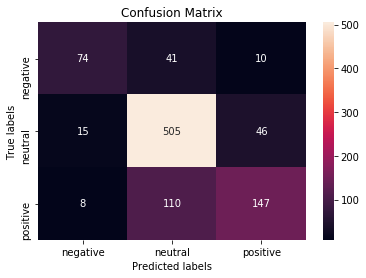

In [4]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(df_phrase['text'], 
                                                    df_phrase['sentiment'], 
                                                    test_size=config.TEST_SIZE, 
                                                    random_state = config.RANDOM_STATE)

# reset indicies -- required for heirachical classifier
# comparisson of models misclassified indicies in seperate notebook
# indicies required to be in line accross notebooks
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# model
model = Pipeline([('tfidf', TfidfVectorizer()),
                 ('model', LinearSVC())])

# evaluator fits, predicts and returns metrics for model
_eval = evaluator.evaluator('tfid & svc', model, X_train, y_train, X_test, y_test)
_eval.plot_confusion()
_eval.get_results()

In [5]:
_eval.save_results('results/results.csv')

# Model Parameters

In [6]:
param='C'
for i, param_val in enumerate([0.5, 0.55, 0.6, 0.65, 0.7,0.75,0.8]):
    if i ==0:
        # model
        model = Pipeline([('tfidf', TfidfVectorizer()),('model', LinearSVC(C=param_val))])

        # evaluator fits, predicts and returns metrics for model
        _eval = evaluator.evaluator('ar', model, X_train, y_train, X_test, y_test)
        results_all = _eval.get_results()
        results_all['param_val'] = param_val
    else:
        # model
        model = Pipeline([('tfidf', TfidfVectorizer()),('model', LinearSVC(C=param_val))])

        # evaluator fits, predicts and returns metrics for model
        _eval = evaluator.evaluator('ar', model, X_train, y_train, X_test, y_test)
        results = _eval.get_results()
        results['param_val'] = param_val    
        results_all = results_all.append(results, sort=False)

In [7]:
results_all = results_all[results_all.result=='cross validation']
results_all.reset_index(inplace=True, drop=True)
results_all.param_val.fillna(0, inplace=True)

results_formatted = {'experiment':[],'param':[],'param_val':[],'metric':[],'value':[]}
for i in list(results_all.index):
    results = results_all.iloc[i]
    for metric in ['accuarcy', 'precision', 'recall']:
        results_formatted['experiment'].append(results.experiment)
        results_formatted['param'].append(param)
        results_formatted['param_val'].append(results.param_val)
        results_formatted['metric'].append(metric)
        results_formatted['value'].append(results[metric])
results_formatted = pd.DataFrame(results_formatted)


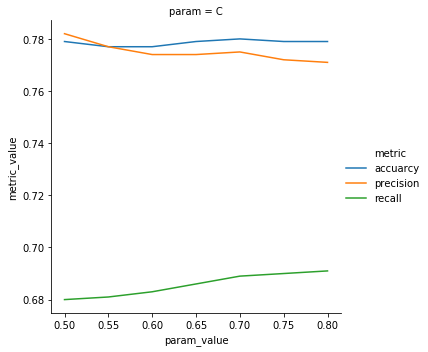

In [8]:
# create facetgrid
g = sns.FacetGrid(results_formatted, col='param', col_wrap=1, sharex=False, legend_out=True, height=5);
g.map(sns.lineplot, 'param_val', 'value', 'metric');

g.add_legend();

#g.fig.suptitle('Figure X',x=0, y=0, verticalalignment = 'bottom', horizontalalignment='left');

g.set_axis_labels('param_value', 'metric_value');
